## INFORME FINAL:

### Retomando el Proyecto_03, sobre series de tiempo, se procederá a agregar al trabajo información de otros años acerca de la variable a predecir en cuestión ("Cantidad de pasos de vehículos por peaje"), con el fin de nutrir a los modelos a entrenar. Además, se profundizará en el análisis exploratorio de datos y se justificará el preprocesamiento previo a las proyecciones y sus evaluaciones. 
### Por otra parte, se implementará el algoritmo XGBoost con variables categóricas anteriormente codificadas y se ahondará en el uso de la librería Prophet, la cual se basa en una predicción final que combina tendencia, estacionalidad y error esperable.
### Sobre el final del notebook, se hallarán los links a los repositorios de Github.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set()
import datetime
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
import scipy as stats
import warnings
warnings.filterwarnings("ignore")

In [185]:
data_2019 = pd.read_csv('C:/Users/guido/Desktop/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('C:/Users/guido/Desktop/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('C:/Users/guido/Desktop/flujo-vehicular-2017.csv', sep =',')
data_2016 = pd.read_csv('C:/Users/guido/Desktop/flujo-vehicular-2016.csv', sep =',')
data_2015 = pd.read_csv('C:/Users/guido/Desktop/flujo-vehicular-2015.csv', sep =',')
data_2014 = pd.read_csv('C:/Users/guido/Desktop/flujo-vehicular-2014.csv', sep =',')

In [128]:
datos = [data_2019, data_2018, data_2017, data_2016, data_2015, data_2014]

In [4]:
for años in datos:
    print('Las columnas del dataset son:', años.columns)

Las columnas del dataset son: Index(['periodo', 'fecha', 'hora_inicio', 'hora_fin', 'dia', 'estacion',
       'sentido', 'tipo_vehiculo', 'forma_pago', 'cantidad_pasos'],
      dtype='object')
Las columnas del dataset son: Index(['periodo', 'fecha', 'hora_inicio', 'hora_fin', 'dia', 'estacion',
       'sentido', 'tipo_vehiculo', 'forma_pago', 'cantidad_pasos'],
      dtype='object')
Las columnas del dataset son: Index(['periodo', 'fecha', 'hora_inicio', 'hora_fin', 'dia', 'estacion',
       'sentido', 'tipo_vehiculo', 'forma_pago', 'cantidad_pasos'],
      dtype='object')
Las columnas del dataset son: Index(['periodo', 'fecha', 'hora_inicio', 'hora_fin', 'dia', 'estacion',
       'sentido', 'tipo_vehiculo', 'forma_pago', 'cantidad_pasos'],
      dtype='object')
Las columnas del dataset son: Index(['periodo', 'fecha', 'hora', 'dia', 'estacion', 'tipo_vehiculo',
       'forma_pago', 'cantidad_pasos'],
      dtype='object')
Las columnas del dataset son: Index(['periodo', 'fecha', 'hora', 

In [5]:
for años in datos:
    print('Las estaciones del dataset son:', años.estacion.unique())

Las estaciones del dataset son: ['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
Las estaciones del dataset son: ['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
Las estaciones del dataset son: ['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
Las estaciones del dataset son: ['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
Las estaciones del dataset son: ['Alberdi' 'Avellaneda' 'Dellepiane Liniers' 'Illia' 'Retiro' 'Sarmiento'
 'Dellepiane Centro' 'Salguero']
Las estaciones del dataset son: ['Alberdi' 'Avellaneda' 'Dellepiane Liniers' 'Illia' 'Retiro' 'Sarmiento'
 nan]


In [186]:
data_2015_2014 = pd.concat([data_2015, data_2014])

In [187]:
data_2015_2014.rename(columns = {'hora':'hora_fin'}, inplace = True) 

In [188]:
dataset = pd.concat([data_2019, data_2018, data_2017, data_2016, data_2015_2014])

In [189]:
dataset.shape

(6767483, 10)

### El dataset con los seis años concatenados -2014-2019-, y sin filtros aplicados, presenta 6.767.483 registros y 10 variables (columnas).

In [10]:
dataset.head().append(dataset.tail())

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019.0,2019-01-01,0.0,1.0,Martes,Alberti,Centro,Liviano,NO COBRADO,22.0
1,2019.0,2019-01-01,0.0,1.0,Martes,Alberti,Centro,Liviano,TELEPASE,6.0
2,2019.0,2019-01-01,0.0,1.0,Martes,Alberti,Provincia,Liviano,NO COBRADO,53.0
3,2019.0,2019-01-01,0.0,1.0,Martes,Alberti,Provincia,Liviano,TELEPASE,18.0
4,2019.0,2019-01-01,0.0,1.0,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16.0
809371,2014.0,2014-12-31,NaN,21.0,Miercoles,Sarmiento,NaN,Liviano,AUPASS,82.0
809372,2014.0,2014-12-31,NaN,22.0,Miercoles,Sarmiento,NaN,Liviano,NO COBRADO,5.0
809373,2014.0,2014-12-31,NaN,22.0,Miercoles,Sarmiento,NaN,Liviano,AUPASS,5.0
809374,2014.0,2014-12-31,NaN,23.0,Miercoles,Sarmiento,NaN,Liviano,NO COBRADO,2.0
809375,2014.0,2014-12-31,NaN,23.0,Miercoles,Sarmiento,NaN,Liviano,AUPASS,3.0


### ¿Cómo se distribuyen los pasos por cada estación?

In [11]:
dataset.groupby('estacion')['cantidad_pasos'].sum().sort_values(ascending=False)

estacion
Avellaneda            298670909.0
Illia                 196636446.0
Dellepiane Liniers     92338996.0
Dellepiane Centro      61696366.0
Dellepiane             29295448.0
Alberdi                28254228.0
Retiro                 12634134.0
PDB                     5668376.0
Alberti                 5631401.0
Sarmiento               5544676.0
Salguero                3198324.0
Name: cantidad_pasos, dtype: float64

### Procedo a unificar criterios para los registros de la variable "Estación":

In [190]:
dataset['estacion'] = dataset['estacion'].replace('Alberti', 'Alberdi')
dataset['estacion'] = dataset['estacion'].replace('Dellepiane Liniers', 'Dellepiane')
dataset['estacion'] = dataset['estacion'].replace('Dellepiane Centro', 'Dellepiane')
dataset.estacion[dataset.estacion == 'PDB'] = np.nan
dataset = dataset.dropna(subset=['estacion'])

In [13]:
pasos_por_estacion = dataset.groupby('estacion')['cantidad_pasos'].sum().sort_values(ascending=False)

In [14]:
pasos_por_estacion

estacion
Avellaneda    298670909.0
Illia         196636446.0
Dellepiane    183330810.0
Alberdi        33885629.0
Retiro         12634134.0
Sarmiento       5544676.0
Salguero        3198324.0
Name: cantidad_pasos, dtype: float64

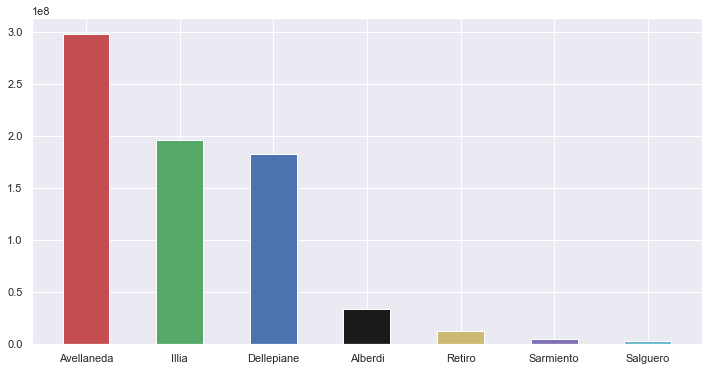

In [15]:
estaciones = ['Avellaneda', 'Illia', 'Dellepiane', 'Alberdi', 'Retiro', 'Sarmiento', 'Salguero']
colores = 'rgbkymc'
plt.figure(figsize=(12,6))
plt.bar(estaciones, pasos_por_estacion, width=0.5, color=colores)
plt.show()

### _La estación "Avellaneda" presenta casi 300 millones de pasos de vehículos, mientras que "Illia", sobre la cual se había centrado el Proyecto_3, cuenta con alrededor de 100 millones de pasos menos que la primera (196.636.446).

### ¿Y cómo se distribuyen los pasos por cada estación según el año?

In [16]:
dataset[['periodo','estacion','cantidad_pasos']].groupby(['periodo','estacion']).agg({'cantidad_pasos': 'sum'})

cantidad_pasos
periodo estacion                  
2014.0  Alberdi          5399660.0
        Avellaneda      50532349.0
        Dellepiane      31601914.0
        Illia           27979363.0
        Retiro           1775542.0
        Sarmiento         266985.0
2015.0  Alberdi          5672641.0
        Avellaneda      48817442.0
        Dellepiane      30719117.0
        Illia           32516683.0
        Retiro           3226067.0
        Salguero          100159.0
        Sarmiento         977092.0
2016.0  Alberdi          5657571.0
        Avellaneda      50553534.0
        Dellepiane      31257553.0
        Illia           33924611.0
        Retiro           2710565.0
        Salguero          307902.0
        Sarmiento         934847.0
2017.0  Alberdi          5789514.0
        Avellaneda      50811590.0
        Dellepiane      30693934.0
        Illia           33570584.0
        Retiro           2352828.0
        Salguero          616828.0
        Sarmiento         998212.0
2018.0  Alberdi          5734842.0
        Avellaneda      49652369.0
        Dellepiane      29762844.0
        Illia           34490038.0
        Retiro           1398682.0
        Salguero          952055.0
        Sarmiento        1102862.0
2019.0  Alberdi          5631401.0
        Avellaneda      48303625.0
        Dellepiane      29295448.0
        Illia           34155167.0
        Retiro           1170450.0
        Salguero         1221380.0
        Sarmiento        1264678.0

### La estación Avellaneda presenta muestras parejas de cantidad de pasos a lo largo de los seis años (entre 48 y 50 millones por año aproximadamente). Por lo tanto, debido a ser el peaje con mayor cantidad de pasos registrados y presentar números balanceados anualmente, se eligirá como filtro a aplicar para predecir.

In [191]:
#La variable "dataset_xgboost" será utilizada sobre el final del trabajo.
dataset_xgboost = dataset

dataset = dataset[dataset.estacion=='Avellaneda']

In [146]:
dataset.groupby('estacion')['cantidad_pasos'].sum().sort_values(ascending=False)

estacion
Avellaneda    298670909.0
Name: cantidad_pasos, dtype: float64

### Veamos qué ocurre con respecto a la variable "Forma de pago":

In [147]:
dataset.groupby('forma_pago')['cantidad_pasos'].sum().sort_values(ascending=False)

forma_pago
EFECTIVO                166235857.0
TELEPASE                 61499891.0
AUPASS                   43285529.0
NO COBRADO               18060049.0
EXENTO                    4217188.0
TARJETA DISCAPACIDAD      3026461.0
INFRACCION                1881430.0
T. DISCAPACIDAD            409919.0
MONEDERO                    54585.0
Name: cantidad_pasos, dtype: float64

### Procedo a unificar criterios para los registros de la variable "Forma de pago":

#### Por ejemplo, "AUPASS" pasó a ser denominado "TELEPASE" a partir de 2017.

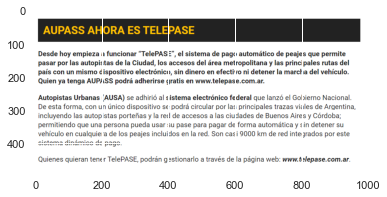

In [20]:
import matplotlib.image as mpimg
img = mpimg.imread('C:/Users/guido/Desktop/telepase.png')
plt.imshow(img)

In [137]:
dataset['forma_pago'] = dataset['forma_pago'].replace('AUPASS', 'TELEPASE')
dataset['forma_pago'] = dataset['forma_pago'].replace('T. DISCAPACIDAD', 'TARJETA DISCAPACIDAD')
dataset['forma_pago'] = dataset['forma_pago'].replace('EXENTO', 'NO COBRADO')

In [22]:
pasos_por_pago = dataset.groupby('forma_pago')['cantidad_pasos'].sum().sort_values(ascending=False)

In [23]:
pasos_por_pago

forma_pago
EFECTIVO                166235857.0
TELEPASE                104785420.0
NO COBRADO               22277237.0
TARJETA DISCAPACIDAD      3436380.0
INFRACCION                1881430.0
MONEDERO                    54585.0
Name: cantidad_pasos, dtype: float64

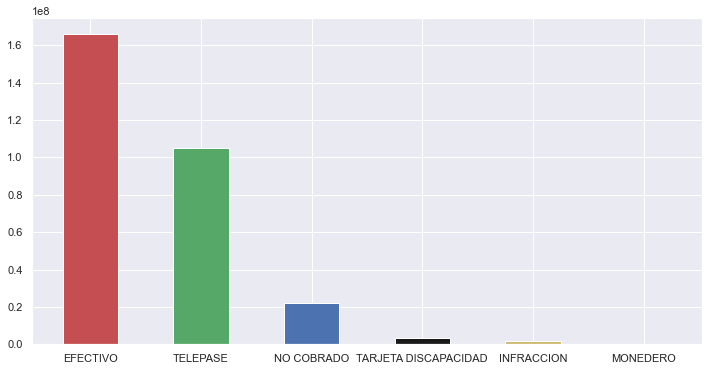

In [24]:
pagos = ['EFECTIVO', 'TELEPASE', 'NO COBRADO', 'TARJETA DISCAPACIDAD', 'INFRACCION', 'MONEDERO']
colores = 'rgbkym'
plt.figure(figsize=(12,6))
plt.bar(pagos, pasos_por_pago, width=0.5, color=colores)
plt.show()

In [25]:
dataset[['periodo','forma_pago','cantidad_pasos']].groupby(['periodo','forma_pago']).agg({'cantidad_pasos': 'sum'})

cantidad_pasos
periodo forma_pago                          
2014.0  EFECTIVO                  31458560.0
        INFRACCION                  244895.0
        MONEDERO                     17759.0
        NO COBRADO                 4088466.0
        TARJETA DISCAPACIDAD        609972.0
        TELEPASE                  14112697.0
2015.0  EFECTIVO                  30450741.0
        INFRACCION                  184890.0
        MONEDERO                     26795.0
        NO COBRADO                 3635390.0
        TARJETA DISCAPACIDAD        537991.0
        TELEPASE                  13981635.0
2016.0  EFECTIVO                  30443074.0
        INFRACCION                  268066.0
        MONEDERO                     10031.0
        NO COBRADO                 3977663.0
        TARJETA DISCAPACIDAD        663503.0
        TELEPASE                  15191197.0
2017.0  EFECTIVO                  28039666.0
        INFRACCION                  300525.0
        NO COBRADO                 3831932.0
        TARJETA DISCAPACIDAD        720965.0
        TELEPASE                  17918502.0
2018.0  EFECTIVO                  24018452.0
        INFRACCION                  350286.0
        NO COBRADO                 4297808.0
        TARJETA DISCAPACIDAD        494030.0
        TELEPASE                  20491793.0
2019.0  EFECTIVO                  21825364.0
        INFRACCION                  532768.0
        NO COBRADO                 2445978.0
        TARJETA DISCAPACIDAD        409919.0
        TELEPASE                  23089596.0

### _Las formas de pago "EFECTIVO" y "TELEPASE" representan alrededor de 260 millones de pasos de vehículos, marcando una esperada diferencia con el resto de las alternativas. Por otra parte, haciendo el recorrido año por año, se percibe una tendencia decreciente en "EFECTIVO" y una creciente en "TELEPASE", convirtiéndose esta última en la opción más elegida durante el último año del dataset (2019).

### Ya habiendo aplicado un primer filtro sobre la variable "Estación", se optará por centrar el análisis en aquellos pasos de vehículos que hayan registrado pagos, ya sea en efectivo o mediante Telepase (variable "Forma de pago"). El fin del presente trabajo será proyectar la "Cantidad de pasos" -variable "y"- de vehículos que abonarán en la estacíón Avellaneda en el año 2019. Los años 2014, 2015, 2016, 2017 y 2018 serán usados para entrenar al modelo Prophet previo a la predicción final.

In [138]:
filtro = np.logical_or(dataset.forma_pago == 'EFECTIVO', dataset.forma_pago == 'TELEPASE')
dataset = dataset[filtro]

In [27]:
dataset.forma_pago.unique()

array(['EFECTIVO', 'TELEPASE'], dtype=object)

In [28]:
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

In [29]:
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 

In [30]:
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Miercoles,NaN,Liviano,24.0,2014-01-01
1,Miercoles,NaN,Liviano,530.0,2014-01-01
2,Miercoles,NaN,Liviano,176.0,2014-01-01
3,Miercoles,NaN,Pesado,1.0,2014-01-01
4,Miercoles,NaN,Pesado,4.0,2014-01-01


In [31]:
vehiculos = dataset.groupby('tipo_vehiculo')['cantidad_pasos'].sum().sort_values(ascending=False)

In [32]:
vehiculos

tipo_vehiculo
Liviano    242569145.0
Pesado      28452132.0
Name: cantidad_pasos, dtype: float64

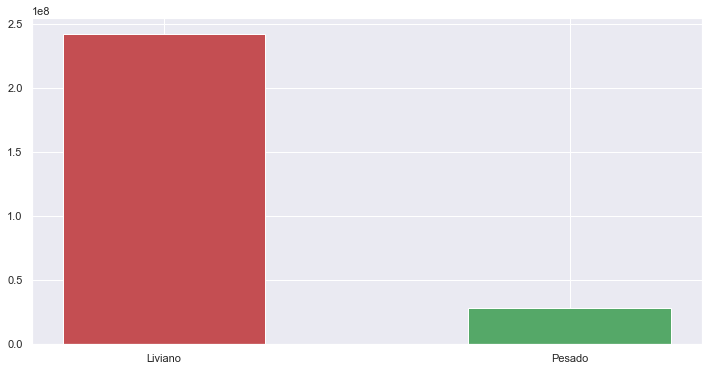

In [33]:
tipo_vehiculo = ['Liviano', 'Pesado']
colores = 'rg'
plt.figure(figsize=(12,6))
plt.bar(tipo_vehiculo, vehiculos, width=0.5, color=colores)
plt.show()

### Debido a la marcada diferencia entre tipos de vehículo, nos centraremos en los livianos

In [34]:
dataset = dataset[dataset.tipo_vehiculo=='Liviano']

In [35]:
dataset.drop(columns=['tipo_vehiculo'], inplace = True)

In [36]:
dataset.groupby('sentido')['cantidad_pasos'].sum().sort_values(ascending=False)

sentido
Provincia    82443938.0
Centro       79063952.0
Name: cantidad_pasos, dtype: float64

### El dataset se encuentra balanceado en lo referido a la columna "Sentido"

In [37]:
dataset_diario = dataset.resample('D', on = 'fecha').sum()
print(dataset_diario.shape)
dataset_diario.head()

(2191, 1)


,cantidad_pasos
fecha,
2014-01-01,90898.0
2014-01-02,109656.0
2014-01-03,122569.0
2014-01-04,99438.0
2014-01-05,86531.0


In [38]:
dataset_diario.cantidad_pasos.describe()

count      2191.000000
mean     110711.613419
std       13526.981763
min           0.000000
25%      104848.500000
50%      113746.000000
75%      119604.000000
max      140533.000000
Name: cantidad_pasos, dtype: float64

In [39]:
primer_cuartil = np.quantile(dataset_diario['cantidad_pasos'], 0.25)
tercer_cuartil = np.quantile(dataset_diario['cantidad_pasos'], 0.75)
rango_intercuartílico = tercer_cuartil - primer_cuartil
mínimo_permitido = primer_cuartil - (1.5*rango_intercuartílico)
máximo_permitido = tercer_cuartil + (1.5*rango_intercuartílico)
outliers = dataset_diario[(dataset_diario.cantidad_pasos < mínimo_permitido) | (dataset_diario.cantidad_pasos > máximo_permitido)]

In [40]:
outliers

,cantidad_pasos
fecha,
2014-02-02,79355.0
2014-02-09,81685.0
2014-03-04,78887.0
2014-03-12,81079.0
2014-04-02,81249.0
...,...
2019-06-30,82700.0
2019-09-07,80496.0
2019-10-02,82208.0


In [41]:
dataset_diario.cantidad_pasos[dataset_diario.cantidad_pasos > máximo_permitido] = np.nan
dataset_diario.cantidad_pasos[dataset_diario.cantidad_pasos < mínimo_permitido] = np.nan
dataset_diario.isna().sum()

cantidad_pasos    94
dtype: int64

In [42]:
dataset_diario = dataset_diario.interpolate(method='time')
print(dataset_diario.isna().sum())

cantidad_pasos    0
dtype: int64


In [43]:
dataset_diario

,cantidad_pasos
fecha,
2014-01-01,90898.0
2014-01-02,109656.0
2014-01-03,122569.0
2014-01-04,99438.0
2014-01-05,86531.0
...,...
2019-12-27,129896.0
2019-12-28,98001.0
2019-12-29,101951.5


### Descomposición de la serie de tiempo


In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(dataset_diario.cantidad_pasos, model='additive')

### Observamos tendencia, estacionalidad y ruido:

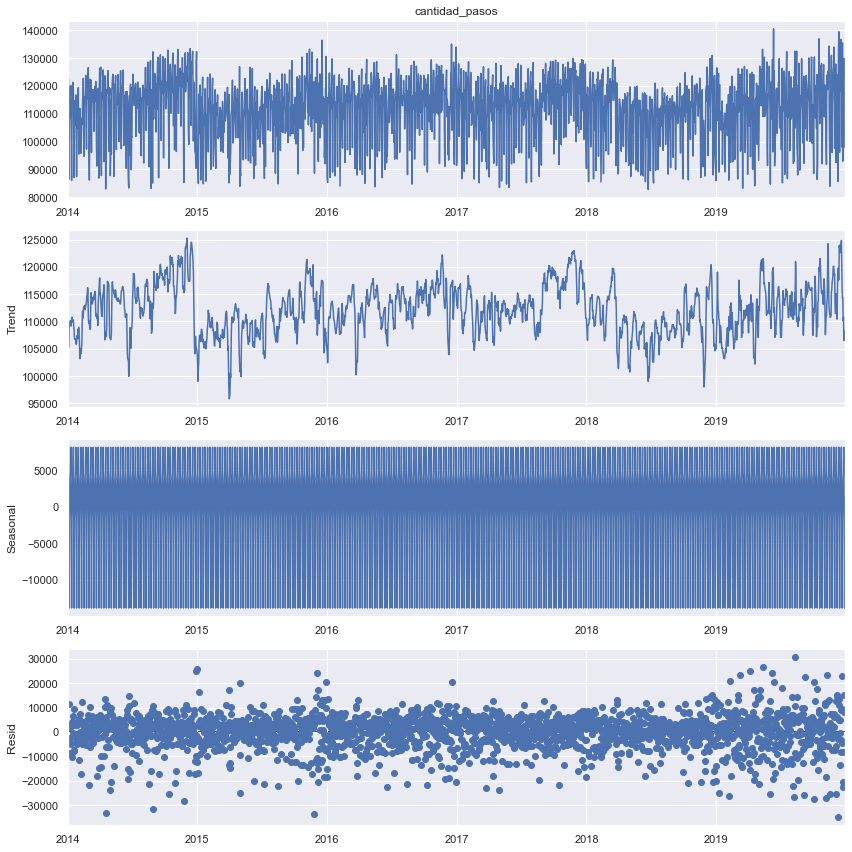

In [45]:
plt.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

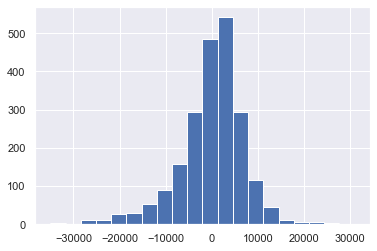

In [46]:
plt.figure(figsize = (6,4))
plt.hist(result.resid, bins = 20)
plt.show()

### Presencia de una distribución normal del "ruido".

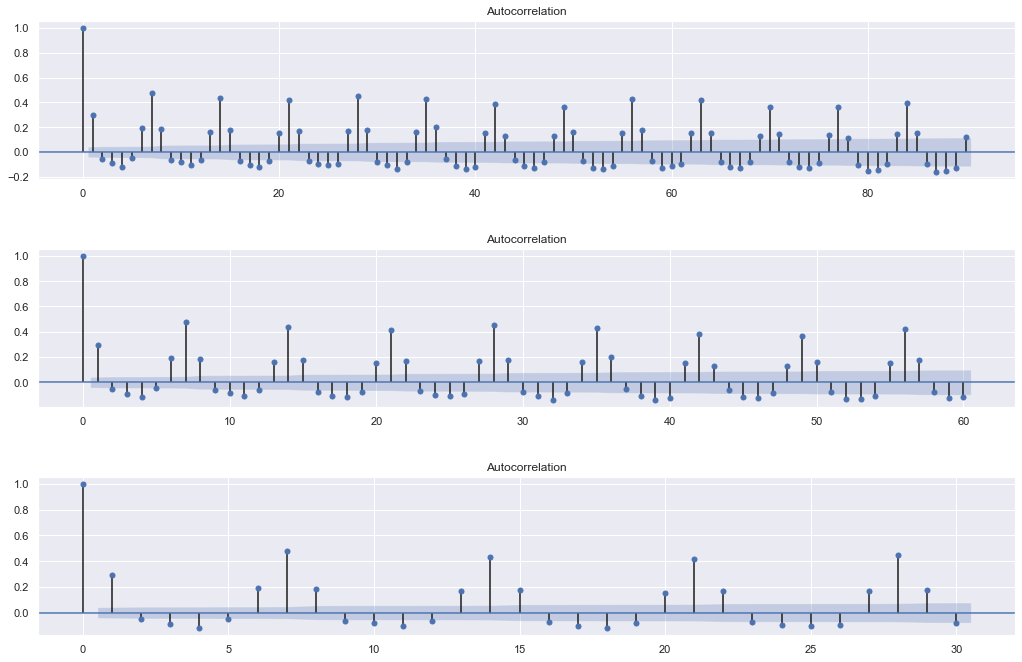

In [47]:
plt.figure(figsize=(15,10))
plt.subplot(311)
plot_acf(dataset_diario.cantidad_pasos, lags=90, ax=plt.gca())
plt.subplot(312)
plot_acf(dataset_diario.cantidad_pasos, lags=60, ax=plt.gca())
plt.subplot(313)
plot_acf(dataset_diario.cantidad_pasos, lags=30, ax=plt.gca())
plt.tight_layout(pad=3.0)
plt.show()

### PROPHET:

In [215]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import itertools

In [216]:
df_diario = dataset_diario.reset_index()

In [217]:
df_diario.columns = ['ds','y']

In [218]:
df_diario.head()

,ds,y
0,2014-01-01,90898.0
1,2014-01-02,109656.0
2,2014-01-03,122569.0
3,2014-01-04,99438.0
4,2014-01-05,86531.0


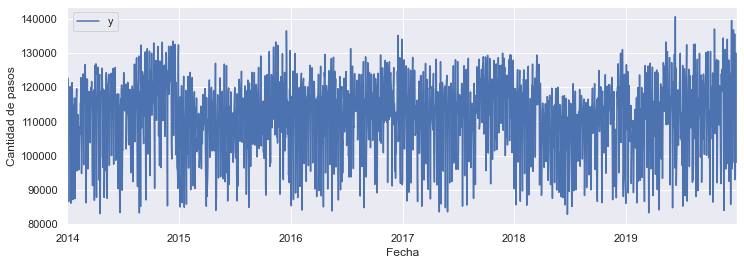

In [220]:
ax = df_diario.set_index('ds').plot(figsize = (12, 4))
ax.set_ylabel('Cantidad de pasos')
ax.set_xlabel('Fecha')
plt.show()

In [221]:
df_diario.shape

(2191, 2)

In [222]:
df_diario_prediccion = df_diario.tail(365)

In [223]:
df_diario_prediccion

,ds,y
1826,2019-01-01,85998.0
1827,2019-01-02,121177.0
1828,2019-01-03,126501.0
1829,2019-01-04,121780.0
1830,2019-01-05,114650.5
...,...,...
2186,2019-12-27,129896.0
2187,2019-12-28,98001.0
2188,2019-12-29,101951.5
2189,2019-12-30,105902.0


In [224]:
prediction_size = 365
train_df = df_diario.iloc[:-prediction_size]

In [225]:
train_df.shape

(1826, 2)

In [226]:
modelo = Prophet(daily_seasonality=True, weekly_seasonality=True)
modelo.fit(train_df)

In [227]:
future = modelo.make_future_dataframe(periods=prediction_size)

In [228]:
future

,ds
0,2014-01-01
1,2014-01-02
2,2014-01-03
3,2014-01-04
4,2014-01-05
...,...
2186,2019-12-27
2187,2019-12-28
2188,2019-12-29
2189,2019-12-30


In [229]:
forecast = modelo.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,95437.722308,106280.238571,124704.347830,95437.722308,95437.722308,20017.591096,20017.591096,20017.591096,18309.227486,...,3901.294916,3901.294916,3901.294916,-2192.931305,-2192.931305,-2192.931305,0.0,0.0,0.0,115455.313404
1,2014-01-02,95435.527344,106131.407116,125489.085583,95435.527344,95435.527344,20460.012435,20460.012435,20460.012435,18309.227486,...,4767.119582,4767.119582,4767.119582,-2616.334633,-2616.334633,-2616.334633,0.0,0.0,0.0,115895.539779
2,2014-01-03,95433.332381,109631.114621,127906.726329,95433.332381,95433.332381,23503.987457,23503.987457,23503.987457,18309.227486,...,8201.604002,8201.604002,8201.604002,-3006.844031,-3006.844031,-3006.844031,0.0,0.0,0.0,118937.319837
3,2014-01-04,95431.137417,98295.637308,117338.580854,95431.137417,95431.137417,12868.407404,12868.407404,12868.407404,18309.227486,...,-2082.098982,-2082.098982,-2082.098982,-3358.721099,-3358.721099,-3358.721099,0.0,0.0,0.0,108299.544822
4,2014-01-05,95428.942454,85409.707363,104424.795310,95428.942454,95428.942454,-95.530852,-95.530852,-95.530852,18309.227486,...,-14737.775163,-14737.775163,-14737.775163,-3666.983175,-3666.983175,-3666.983175,0.0,0.0,0.0,95333.411602


In [232]:
año2019 = forecast.tail(365)

In [233]:
año2019

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1826,2019-01-01,87923.351016,96048.089813,115499.984510,87923.351016,87923.351016,17717.246636,17717.246636,17717.246636,18309.227486,...,1490.693318,1490.693318,1490.693318,-2082.674168,-2082.674168,-2082.674168,0.0,0.0,0.0,105640.597652
1827,2019-01-02,87904.333038,97619.361645,117660.666521,87904.333038,87904.333038,19697.193643,19697.193643,19697.193643,18309.227486,...,3901.294916,3901.294916,3901.294916,-2513.328759,-2513.328759,-2513.328759,0.0,0.0,0.0,107601.526681
1828,2019-01-03,87885.315060,99503.007196,117061.276690,87885.315060,87885.315060,20163.720855,20163.720855,20163.720855,18309.227486,...,4767.119582,4767.119582,4767.119582,-2912.626213,-2912.626213,-2912.626213,0.0,0.0,0.0,108049.035915
1829,2019-01-04,87866.297082,101482.503050,120235.015848,87866.297082,87866.297082,23236.171265,23236.171265,23236.171265,18309.227486,...,8201.604002,8201.604002,8201.604002,-3274.660222,-3274.660222,-3274.660222,0.0,0.0,0.0,111102.468347
1830,2019-01-05,87847.279103,91177.615530,109540.707940,87847.279103,87847.279103,12632.881392,12632.881392,12632.881392,18309.227486,...,-2082.098982,-2082.098982,-2082.098982,-3594.247112,-3594.247112,-3594.247112,0.0,0.0,0.0,100480.160495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2186,2019-12-27,81076.878887,97354.592325,118119.843901,79837.327333,82407.278009,26932.996357,26932.996357,26932.996357,18309.227486,...,8201.604002,8201.604002,8201.604002,422.164870,422.164870,422.164870,0.0,0.0,0.0,108009.875244
2187,2019-12-28,81057.860909,87854.476720,107084.272507,79815.169174,82392.283456,16167.178613,16167.178613,16167.178613,18309.227486,...,-2082.098982,-2082.098982,-2082.098982,-59.949890,-59.949890,-59.949890,0.0,0.0,0.0,97225.039522
2188,2019-12-29,81038.842931,74433.143989,93726.806785,79792.103597,82377.121906,3023.958796,3023.958796,3023.958796,18309.227486,...,-14737.775163,-14737.775163,-14737.775163,-547.493527,-547.493527,-547.493527,0.0,0.0,0.0,84062.801727
2189,2019-12-30,81019.824953,87322.212782,106213.828037,79769.198232,82365.458180,15735.064513,15735.064513,15735.064513,18309.227486,...,-1540.837673,-1540.837673,-1540.837673,-1033.325300,-1033.325300,-1033.325300,0.0,0.0,0.0,96754.889466


In [234]:
año2019[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
2184,2019-12-25,104668.556043,95998.438356,114192.414999
2185,2019-12-26,105064.237734,95265.136718,114944.114645
2186,2019-12-27,108009.875244,97354.592325,118119.843901
2187,2019-12-28,97225.039522,87854.476720,107084.272507
2188,2019-12-29,84062.801727,74433.143989,93726.806785
2189,2019-12-30,96754.889466,87322.212782,106213.828037
2190,2019-12-31,99290.543048,90967.381710,108916.941991


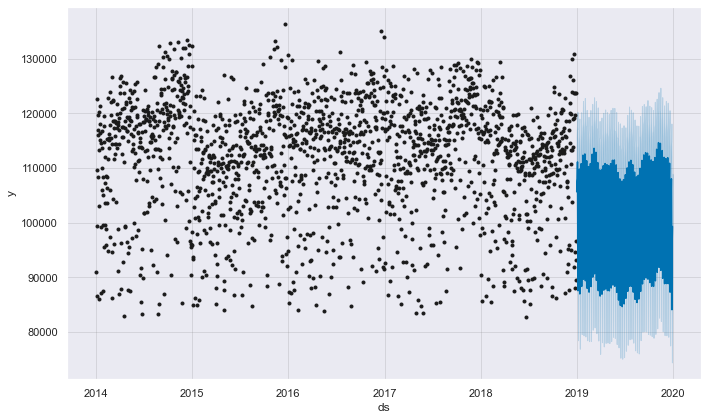

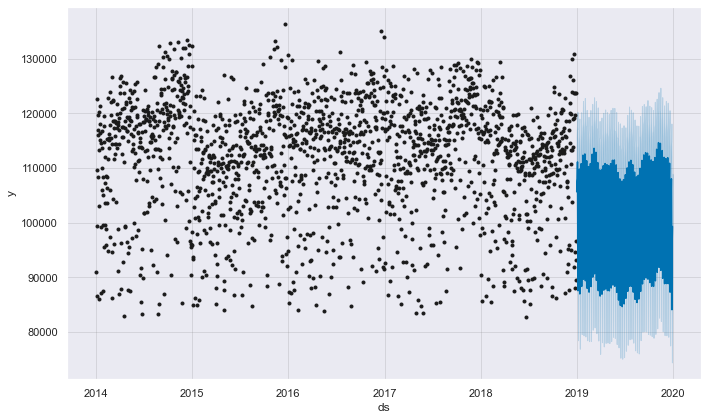

In [235]:
modelo.plot(año2019)

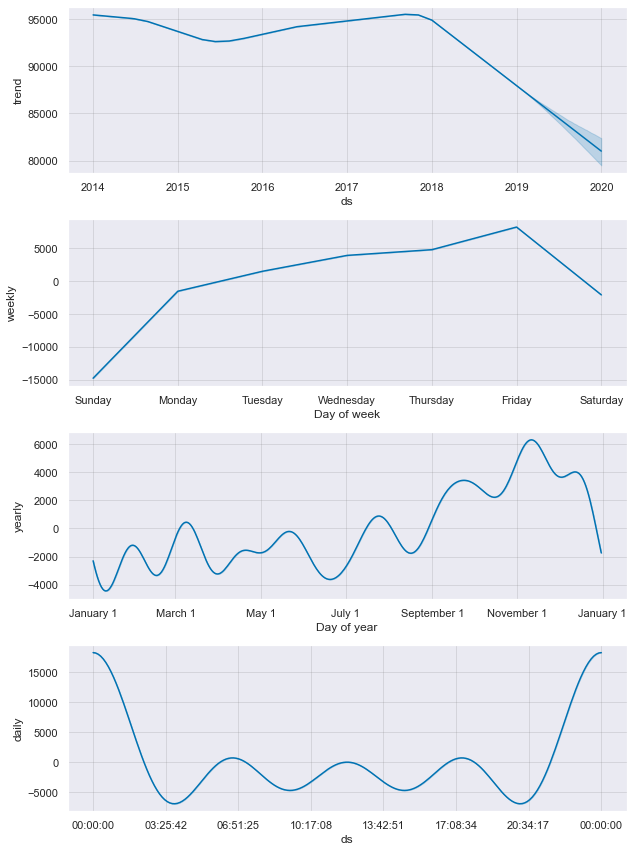

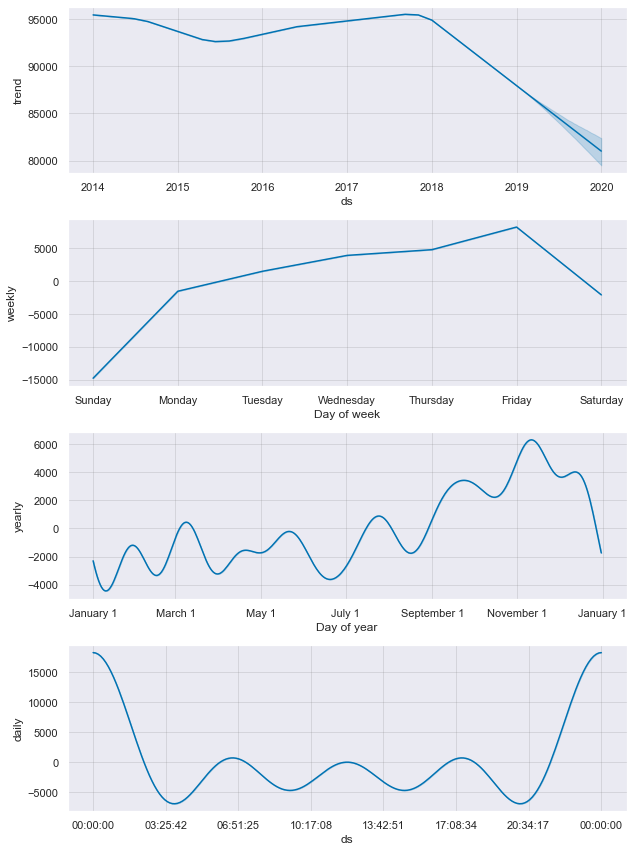

In [67]:
modelo.plot_components(forecast)

In [236]:
def dataframe_evaluación(df_diario_prediccion, año2019):
    return año2019.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_diario_prediccion.set_index('ds'))

In [237]:
df_comparación = dataframe_evaluación(df_diario_prediccion, año2019)

df_comparación

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2019-01-01,105640.597652,96048.089813,115499.984510,85998.0
2019-01-02,107601.526681,97619.361645,117660.666521,121177.0
2019-01-03,108049.035915,99503.007196,117061.276690,126501.0
2019-01-04,111102.468347,101482.503050,120235.015848,121780.0
2019-01-05,100480.160495,91177.615530,109540.707940,114650.5
...,...,...,...,...
2019-12-27,108009.875244,97354.592325,118119.843901,129896.0
2019-12-28,97225.039522,87854.476720,107084.272507,98001.0
2019-12-29,84062.801727,74433.143989,93726.806785,101951.5


In [70]:
from sklearn.metrics import mean_squared_error

def forecast_errors(df_comparación):
    
    df_comparación_resultados = df_comparación
    
    df_comparación_resultados['error'] = df_comparación_resultados['y'] - df_comparación_resultados['yhat']
    
    df_comparación_resultados['porcentaje_error'] = 100 * df_comparación_resultados['error'] / df_comparación_resultados['y']
    
    MSE = mean_squared_error(df_comparación_resultados['y'], df_comparación_resultados['yhat'])
    
    RMSE = np.sqrt(mean_squared_error(df_comparación_resultados['y'], df_comparación_resultados['yhat']))
    
    return df_comparación_resultados, MSE, RMSE

### Elijo como métricas al error cuadrático medio (MSE), por su capacidad para penalizar a aquellos valores predichos que más se alejan de su valor real, y a la raíz del error cuadrático medio (RMSE), con el fin de transformar al número en uno comparable con la "y" (cantidad de pasos) y su media.

In [71]:
forecast_errors(df_comparación)

(                     yhat     yhat_lower     yhat_upper         y  \
 ds                                                                  
 2019-01-01  105640.597652   96104.765530  115395.565067   85998.0   
 2019-01-02  107601.526681   98140.311089  117549.408958  121177.0   
 2019-01-03  108049.035915   98942.879129  117934.156635  126501.0   
 2019-01-04  111102.468347  102030.751238  120276.467866  121780.0   
 2019-01-05  100480.160495   90814.039224  109539.540588  114650.5   
 ...                   ...            ...            ...       ...   
 2019-12-27  108009.875244   98913.998198  117293.170894  129896.0   
 2019-12-28   97225.039522   87926.439557  106545.393347   98001.0   
 2019-12-29   84062.801727   74457.631060   93695.195501  101951.5   
 2019-12-30   96754.889466   86313.666950  106433.564771  105902.0   
 2019-12-31   99290.543048   90001.750855  108721.417396  105902.0   
 
                    error  porcentaje_error  
 ds                                       

In [239]:
df_comparación.y.mean()

112600.26849315068

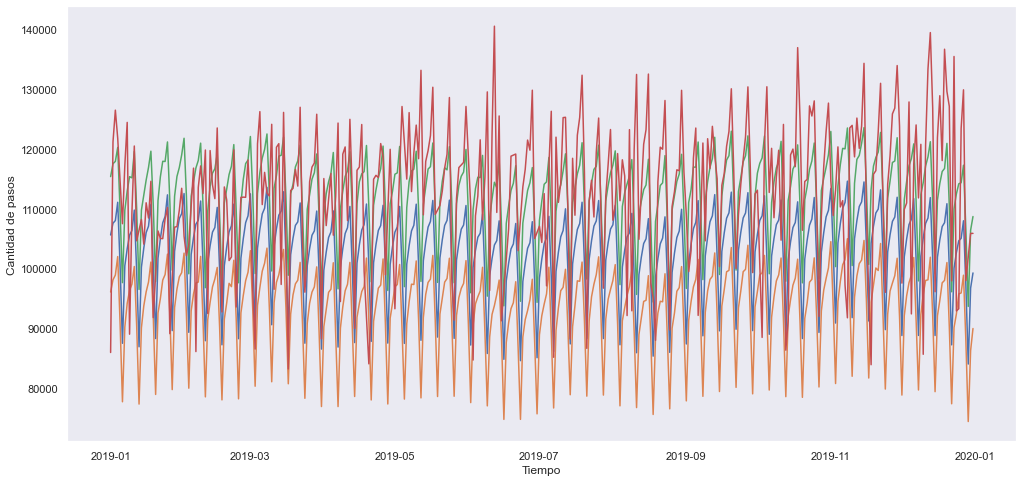

In [72]:
plt.figure(figsize=(17, 8))
plt.plot(df_comparación['yhat'])
plt.plot(df_comparación['yhat_lower'])
plt.plot(df_comparación['yhat_upper'])
plt.plot(df_comparación['y'])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.grid(False)
plt.show()

In [248]:
df_cv = cross_validation(modelo, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)

INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-01-11 00:00:00 and 2017-12-31 00:00:00


In [255]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
1820,2018-12-27,119339.573033,109391.826739,128640.365279,123656.0,2017-12-31
1821,2018-12-28,122627.779765,112758.721912,132944.552230,123715.0,2017-12-31
1822,2018-12-29,112133.219939,102255.707232,121667.766369,96639.0,2017-12-31
1823,2018-12-30,99023.343667,89744.224698,108514.276570,93092.0,2017-12-31
1824,2018-12-31,112207.258531,102417.154474,122344.706411,89545.0,2017-12-31


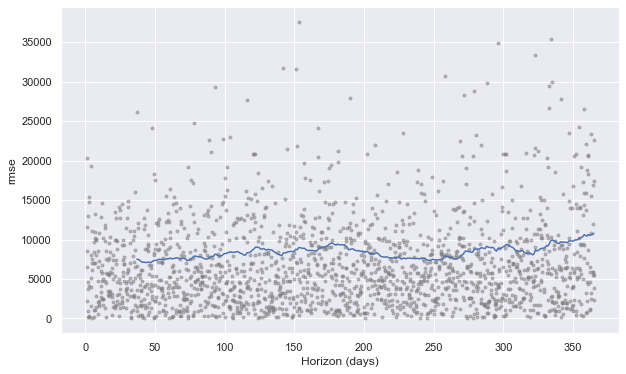

In [254]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

### La mejor performance que arroja el modelo se da con un horizonte de 30 días, el cual mejora el redimiento obtenido previamente. La raíz del error cuadrático medio pasaría de un 14.746 a una cifra cercana al 7.000.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 00:00:00 and 2017-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 00:00:00 and 2017-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 00:00:00 and 2017-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 00:00:00 and 2017-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2015-01-16 00:00:00 and 2017-12-31 00:00:00


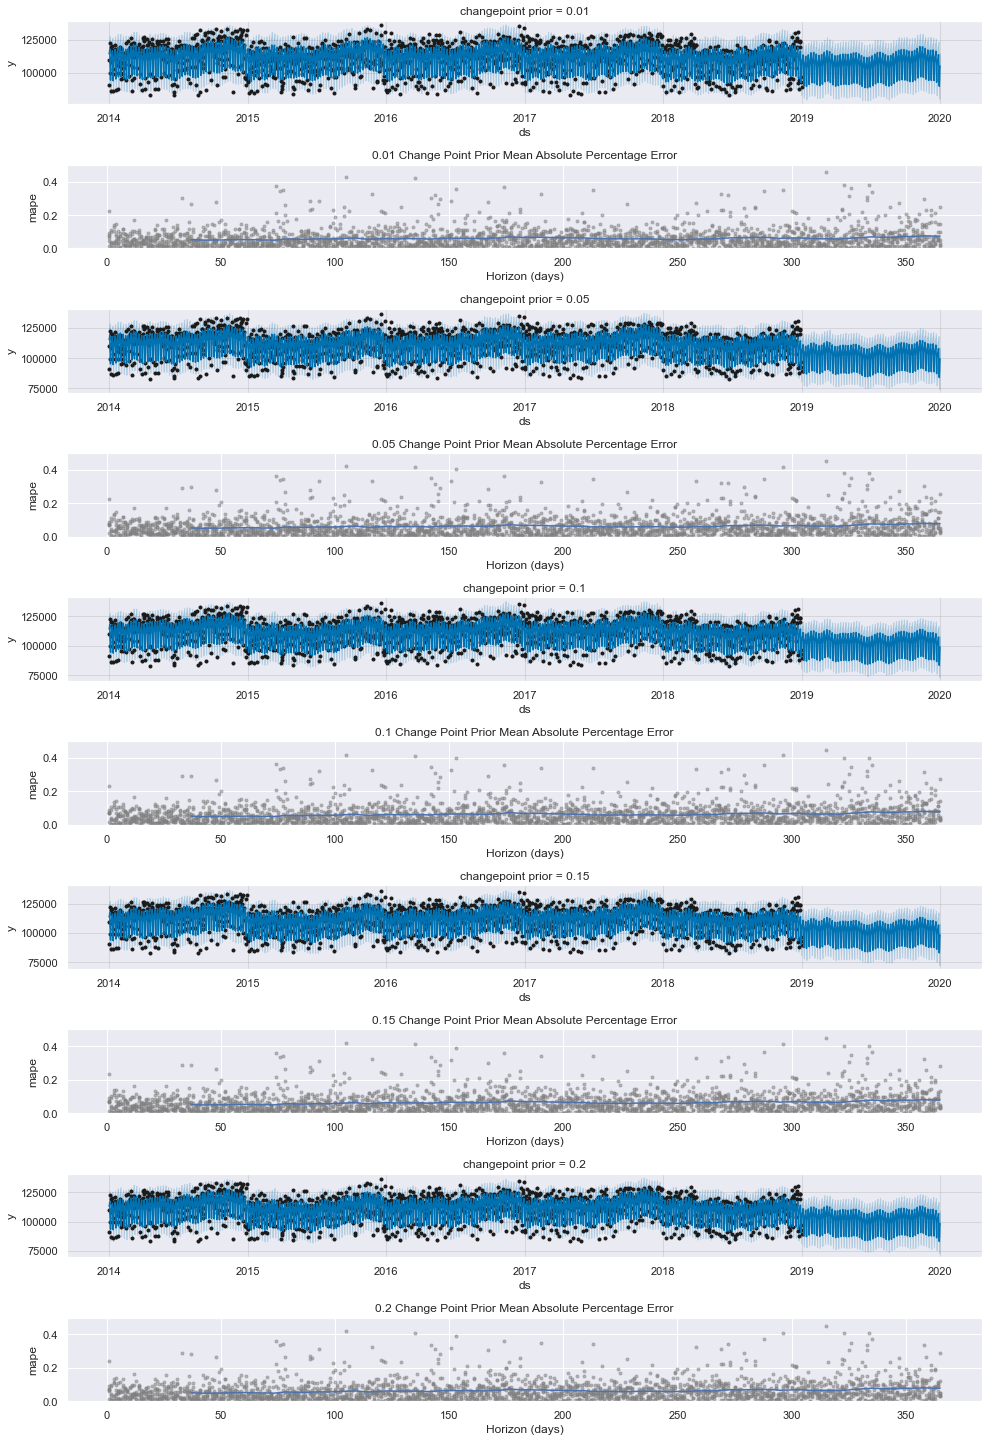

In [247]:
fig, ax = plt.subplots(10,1, figsize = (14, 20))
ax = ax.ravel()
j = 0

for i in [0.01, 0.05, 0.10, 0.15, 0.20]:
    
    m = Prophet(changepoint_prior_scale=i)
    
    m.fit(train_df)
     
    future = m.make_future_dataframe(periods=365)
    
    forecast = m.predict(future)
    
    fig = m.plot(forecast, ax = ax[j])
    ax[j].set_title('changepoint prior = ' + str(i))
    j += 1
    df_cv = cross_validation(m, initial='365 days', period='180 days', horizon = '365 days')
    df_p = performance_metrics(df_cv)
    fig = plot_cross_validation_metric(df_cv, metric='rmse', ax = ax[j])
    ax[j].set_title(str(str(i) + ' Change Point Prior Root Mean Square Error'))
    ax[j].set_ylim(0,0.5)
    j += 1

### Se observa cómo, a pesar de las diversas variaciones del "change_point_prior", la precisión del modelo no muestra cambios significativos. Por lo tanto, se mantendrá el valor por defecto que ofrece la librería (0.05).

### ONE-STEP PREDICTION:

In [73]:
one_step = dataset_diario.cantidad_pasos
one_step.head()

fecha
2014-01-01     90898.0
2014-01-02    109656.0
2014-01-03    122569.0
2014-01-04     99438.0
2014-01-05     86531.0
Freq: D, Name: cantidad_pasos, dtype: float64

In [113]:
look_back = 365

N = one_step.shape[0]
X = np.zeros((N - look_back - 1, look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(1825, 365) (1825,)


In [114]:
for i in range(X.shape[0]):
    X[i,:] = one_step.iloc[i:i+look_back]
    y[i] = one_step.iloc[i+look_back]

In [115]:
N_train = 365 + 365 + 365 + 365 + 365 + 364 - 365 - look_back
N_test = 365
N_total = N_train + N_test
length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(1459, 365) (1459,)
(365, 365) (365,)


In [116]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4).fit(X_train,y_train)

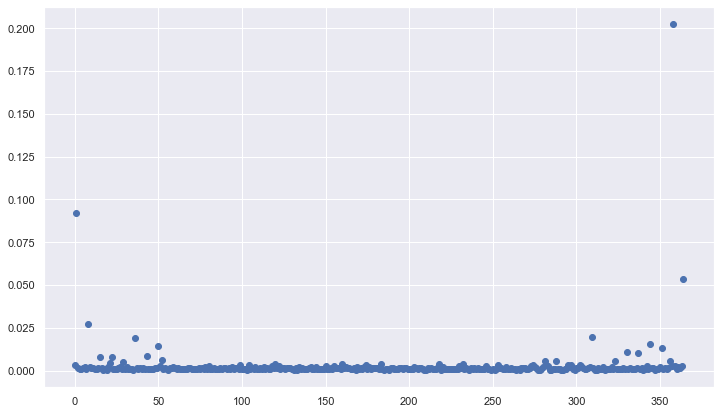

In [117]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(rf.feature_importances_.size),rf.feature_importances_)
plt.show()

In [118]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

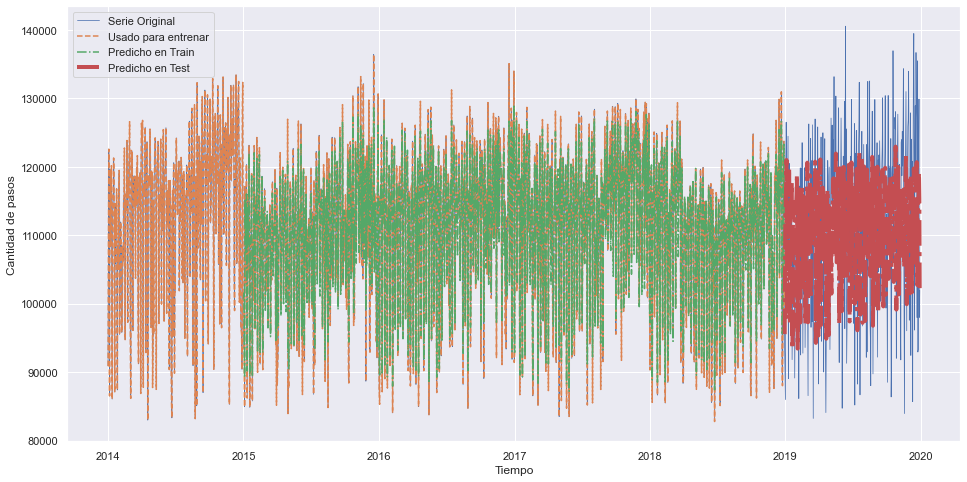

In [119]:
plt.figure(figsize=(16,8))
plt.plot(one_step.index[:length_total], one_step[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(one_step.index[:N_train + look_back], one_step[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(one_step.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(one_step.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

In [120]:
MSE = mean_squared_error(y_train, y_train_pred)
print('Raíz del error cuadrático medio en Train:',np.sqrt(MSE))
MSE = mean_squared_error(y_test, y_test_pred)
print('Raíz del error cuadrático medio en Test:',np.sqrt(MSE))

Raíz del error cuadrático medio en Train: 2677.955364569683
Raíz del error cuadrático medio en Test: 10741.500021876886


### Optimización de hiperparámetros con validación cruzada con búsqueda aleatoria y manual:

In [121]:
from sklearn.model_selection import RandomizedSearchCV

param = {'n_estimators': [300, 325, 350], 'max_depth': [2, 4, 6]}

CV_rfr = RandomizedSearchCV(estimator=rf, param_distributions=param, n_jobs=-1)

CV_rfr.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(n_jobs=4, random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 4, 6],
                                        'n_estimators': [300, 325, 350]})

In [122]:
CV_rfr.best_params_

{'n_estimators': 350, 'max_depth': 6}

In [123]:
random_forest_optimizado = RandomForestRegressor(n_estimators=350, max_depth=6)

random_forest_optimizado.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=350)

In [124]:
y_train_pred = random_forest_optimizado.predict(X_train)
y_test_pred = random_forest_optimizado.predict(X_test)

In [125]:
MSE = mean_squared_error(y_train, y_train_pred)
print('Raíz del error cuadrático medio en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('Raíz del error cuadrático medio en Test:',np.sqrt(MSE))

Raíz del error cuadrático medio en Train: 4841.260463903023
Raíz del error cuadrático medio en Test: 10728.215292794812


### XGBOOST:

In [126]:
import xgboost as xgb

In [192]:
#Retomo dataset guardado sobre el inicio del trabajo.

dataset_xgboost['forma_pago'] = dataset_xgboost['forma_pago'].replace('AUPASS', 'TELEPASE')
dataset_xgboost['forma_pago'] = dataset_xgboost['forma_pago'].replace('T. DISCAPACIDAD', 'TARJETA DISCAPACIDAD')
dataset_xgboost['forma_pago'] = dataset_xgboost['forma_pago'].replace('EXENTO', 'NO COBRADO')

In [193]:
dataset_xgboost.drop(columns = ['periodo','hora_inicio'], inplace = True)

In [194]:
dataset_xgboost['fecha2'] = pd.to_datetime(dataset_xgboost.fecha) + pd.to_timedelta(dataset_xgboost.hora_fin, unit = 'h')

dataset_xgboost.drop(columns=['fecha','hora_fin'], inplace = True)

dataset_xgboost.rename(columns = {'fecha2':'fecha'}, inplace = True)

In [195]:
dataset_xgboost.sort_values('fecha', inplace = True)
dataset_xgboost.reset_index(drop=True, inplace = True)
dataset_xgboost.head()

,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha
0,Miercoles,Dellepiane,NaN,Liviano,TELEPASE,99.0,2014-01-01
1,Miercoles,Avellaneda,NaN,Pesado,EFECTIVO,1.0,2014-01-01
2,Miercoles,Avellaneda,NaN,Liviano,TELEPASE,176.0,2014-01-01
3,Miercoles,Avellaneda,NaN,Liviano,INFRACCION,1.0,2014-01-01
4,Miercoles,Avellaneda,NaN,Liviano,TARJETA DISCAPACIDAD,4.0,2014-01-01


In [196]:
dataset_xgboost = dataset_xgboost.set_index('fecha')

In [197]:
dataset_xgboost['Year'] = dataset_xgboost.index.year
dataset_xgboost['Month'] = dataset_xgboost.index.month
dataset_xgboost['Day'] = dataset_xgboost.index.day
dataset_xgboost['WeekOfYear'] = dataset_xgboost.index.weekofyear

In [198]:
print(dataset_xgboost.shape)
print(dataset_xgboost.head())

(6726517, 10)
                  dia    estacion sentido tipo_vehiculo            forma_pago  \
fecha                                                                           
2014-01-01  Miercoles  Dellepiane     NaN       Liviano              TELEPASE   
2014-01-01  Miercoles  Avellaneda     NaN        Pesado              EFECTIVO   
2014-01-01  Miercoles  Avellaneda     NaN       Liviano              TELEPASE   
2014-01-01  Miercoles  Avellaneda     NaN       Liviano            INFRACCION   
2014-01-01  Miercoles  Avellaneda     NaN       Liviano  TARJETA DISCAPACIDAD   

            cantidad_pasos  Year  Month  Day  WeekOfYear  
fecha                                                     
2014-01-01            99.0  2014      1    1           1  
2014-01-01             1.0  2014      1    1           1  
2014-01-01           176.0  2014      1    1           1  
2014-01-01             1.0  2014      1    1           1  
2014-01-01             4.0  2014      1    1           1  


In [155]:
dataset_xgboost.isnull().sum()

dia                     0
estacion                0
sentido           1827332
tipo_vehiculo           0
forma_pago              0
cantidad_pasos          0
Year                    0
Month                   0
Day                     0
WeekOfYear              0
dtype: int64

In [156]:
dataset_xgboost.sentido.value_counts()

Provincia    2752099
Centro       2147086
Name: sentido, dtype: int64

### Procedo a eliminar los valores faltantes, concernientes a la variable "sentido", ya que la columna se presenta balanceada entre las únicas dos opciones (Provincia y Centro) y con el fin de reducir la cantidad de instancias del dataset.

In [199]:
dataset_xgboost.dropna(inplace=True)

In [200]:
dataset_xgboost.shape

(4899185, 10)

In [162]:
dataset_xgboost.dia.unique()

array(['Viernes', 'Sábado', 'Domingo', 'Lunes', 'Martes', 'Miércoles',
       'Jueves'], dtype=object)

In [163]:
dataset_xgboost.sentido.unique()

array(['Centro', 'Provincia'], dtype=object)

In [164]:
dataset_xgboost.tipo_vehiculo.unique()

array(['Pesado', 'Liviano'], dtype=object)

In [165]:
dataset_xgboost.forma_pago.unique()

array(['EFECTIVO', 'TELEPASE', 'INFRACCION', 'NO COBRADO',
       'TARJETA DISCAPACIDAD', 'MONEDERO', 'Otros'], dtype=object)

### Encoding de variables categóricas

In [201]:
dataset_xgboost['dia'] = dataset_xgboost['dia'].map({'Lunes':1,'Martes':2,'Miercoles':3, 
                                                     'Jueves':4, 'Viernes':5, 'Sabado':6, 'Domingo':7})

dataset_xgboost['sentido'] = dataset_xgboost['sentido'].map({'Centro':1, 'Provincia':2})

dataset_xgboost['tipo_vehiculo'] = dataset_xgboost['tipo_vehiculo'].map({'Pesado':1, 'Liviano':2})

dataset_xgboost['forma_pago'] = dataset_xgboost['forma_pago'].map({'EFECTIVO':1, 'TELEPASE':2, 'INFRACCION':3, 
                                                                   'NO COBRADO':4, 'TARJETA DISCAPACIDAD':5, 'MONEDERO':6, 'Otros':7})

In [202]:
dataset_xgboost = dataset_xgboost[dataset_xgboost.estacion == 'Avellaneda']

In [203]:
dataset_xgboost.drop(columns=['dia', 'estacion'], inplace=True)
dataset_xgboost.head(10)

,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,Year,Month,Day,WeekOfYear
fecha,,,,,,,,
2016-01-01,2,1,2,18.0,2016,1,1,53
2016-01-01,1,1,1,10.0,2016,1,1,53
2016-01-01,1,1,4,4.0,2016,1,1,53
2016-01-01,1,1,1,2.0,2016,1,1,53
2016-01-01,1,2,6,2.0,2016,1,1,53
2016-01-01,1,2,2,375.0,2016,1,1,53
2016-01-01,1,2,3,4.0,2016,1,1,53
2016-01-01,1,2,5,31.0,2016,1,1,53
2016-01-01,1,2,1,1376.0,2016,1,1,53


In [204]:
X = dataset_xgboost[['sentido', 'tipo_vehiculo', 'forma_pago', 'Year', 'Month', 'Day', 'WeekOfYear']]

y = dataset_xgboost[['cantidad_pasos']]

In [205]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [206]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(955373, 7) (955373, 1)
(409446, 7) (409446, 1)


In [207]:
#Variables predictoras:

X.columns

Index(['sentido', 'tipo_vehiculo', 'forma_pago', 'Year', 'Month', 'Day',
       'WeekOfYear'],
      dtype='object')

In [208]:
boosting = xgb.XGBRegressor(objective='reg:squarederror').fit(X_train, y_train)

In [209]:
y_train_pred = boosting.predict(X_train)
y_test_pred = boosting.predict(X_test)

In [210]:
MSE = mean_squared_error(y_train, y_train_pred)
print('RMSE en Train:',np.sqrt(MSE))
MSE = mean_squared_error(y_test, y_test_pred)
print('RMSE en Test:',np.sqrt(MSE))

RMSE en Train: 311.14057126547647
RMSE en Test: 310.56439218304695


## GITHUB:

Proyecto_03: https://github.com/guidogambini/Proyecto_3/blob/main/DS_Proyecto_03_ST%20-%20Gambini%2C%20Guido.ipynb

Informe_Final_Carrera: 